In [1]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import configs.config as cfg
def overlap_percentage(A, B):
    """Calculates the % of pixels in A (nucleus) that overlap with B (cell)."""
    overlap = np.sum(A & B)  # Element-wise AND, counts overlapping 1s
    total_A = np.sum(A)      # Total 1s in A
    return (overlap / total_A) * 100 if total_A > 0 else 0  # Avoid division by zero

# Loading single cell stats and transformed matrix
df = pd.read_csv(f"{cfg.PROJECT_DIR}/shapemode/{cfg.ALIGNMENT}_{cfg.MODE}/transformed_matrix.csv", index_col=0).iloc[:,:6]
meta = pd.read_csv(f"{cfg.PROJECT_DIR}/cell_nu_ratio.txt")
res = []
for imgpath in meta.image_path:
    data = np.load(imgpath.replace('/scratch/users/tle1302/2Dshapespace', '/data/2Dshapespace'))
    res.append(overlap_percentage(data[1,:,:], data[0,:,:]))
meta['nucleus_inside_cell'] = res
meta = meta[(meta.cell_nu_ratio < 8) & (meta.cell_nu_ratio > 1) & (meta.nucleus_inside_cell > 90)]
print(df.shape)
df = df[df.index.isin(meta.image_path)]
print(df.shape)

(31259, 6)
(29760, 6)


In [2]:
meta = pd.read_csv(f"{cfg.PROJECT_DIR}/cell_nu_ratio.txt")
meta['Protein'] = meta.image_path.apply(lambda x: x.split('/')[-3])
meta.groupby('Protein').size()

Protein
CAB079904_USP7      283
CAB079921_PPP1CC    413
CAB080425_KAT2A     384
CAB080426_HDAC8     434
CAB080427_HDAC11    394
                   ... 
HPA074736_KMT2C     401
HPA076218_PRKAG3    284
HPA076873_BRD3      150
HPA077805_PRKAG1    363
NEGATIVE_CTRL       121
Length: 96, dtype: int64

# Shape match

In [3]:
from scipy.spatial.distance import cdist
df['Proteins'] = [f.split('/')[-3] for f in df.index]
df['treatment'] = [f.split('/')[-2].split('_')[2] for f in df.index]
diff = []
labels = []
proteins = []
img_paths = []
for (ab, df_) in df.groupby('Proteins'):
    if ab == 'NEGATIVE_CTRL':
        continue
    shape_d = {}
    shape_d['untreated'] = df_[df_.index.str.contains('untreated')]
    shape_d['vorinostat'] = df_[df_.index.str.contains('Vorinostat')]
    shape_d['paclitaxel'] = df_[df_.index.str.contains('Paclitaxel')]
    distances = cdist(shape_d['untreated'][['PC1','PC2','PC3','PC4','PC5','PC6']], shape_d['vorinostat'][['PC1','PC2','PC3','PC4','PC5','PC6']])
    # find pair of cells that are closest to each other in shape_d
    pairwise_indices = np.argmin(distances, axis=0)  # Get index of closest untreated cell for each treated
    # Collect the closest pairs of indices
    for j, i in enumerate(pairwise_indices):
        imgpath_untreated = shape_d['untreated'].index[i]
        names = imgpath_untreated.split('/')
        img_id = '_'.join([names[-3], names[-2], names[-1]]).replace('.npy', '_protein.npy')
        pilr0 = np.load(f"{cfg.PROJECT_DIR}/sampled_intensity_bin/{img_id}")

        imgpath_vorinostat = shape_d['vorinostat'].index[j]
        names = imgpath_vorinostat.split('/')
        img_id = '_'.join([names[-3], names[-2], names[-1]]).replace('.npy', '_protein.npy')
        pilr1 = np.load(f"{cfg.PROJECT_DIR}/sampled_intensity_bin/{img_id}")
        diff.append((pilr1-pilr0).flatten())
        proteins.append(ab)
        labels.append('vorinostat')
        img_paths.append(shape_d['vorinostat'].index[j])

    distances = cdist(shape_d['untreated'][['PC1','PC2','PC3','PC4','PC5','PC6']], shape_d['paclitaxel'][['PC1','PC2','PC3','PC4','PC5','PC6']])
    # find pair of cells that are closest to each other in shape_d
    pairwise_indices = np.argmin(distances, axis=0)  # Get index of closest untreated cell for each treated
    # Collect the closest pairs of indices
    for j, i in enumerate(pairwise_indices):
        imgpath_untreated = shape_d['untreated'].index[i]
        names = imgpath_untreated.split('/')
        img_id = '_'.join([names[-3], names[-2], names[-1]]).replace('.npy', '_protein.npy')
        pilr0 = np.load(f"{cfg.PROJECT_DIR}/sampled_intensity_bin/{img_id}")

        imgpath_paclitaxel = shape_d['paclitaxel'].index[j]
        names = imgpath_paclitaxel.split('/')
        img_id = '_'.join([names[-3], names[-2], names[-1]]).replace('.npy', '_protein.npy')
        pilr1 = np.load(f"{cfg.PROJECT_DIR}/sampled_intensity_bin/{img_id}")
        diff.append((pilr1-pilr0).flatten())
        proteins.append(ab)
        labels.append('paclitaxel')
        img_paths.append(shape_d['paclitaxel'].index[j])

In [10]:
protein = "NEGATIVE_CTRL"

shape_d = {}
shape_d['untreated'] = df[~df.index.str.contains(protein) & df.index.str.contains('untreated')]
shape_d['vorinostat'] = df[~df.index.str.contains(protein) & df.index.str.contains('Vorinostat')]
shape_d['paclitaxel'] = df[~df.index.str.contains(protein) & df.index.str.contains('Paclitaxel')]
print([(k, v.shape) for k, v in shape_d.items()])

def stack_pilr(df):
    pilr = []
    proteins = []
    for imgpath in df.index:
        names = imgpath.split('/')
        proteins.append(names[-3])
        img_id = '_'.join([names[-3], names[-2], names[-1]]).replace('.npy', '_protein.npy')
        pilr_ = np.load(f"{cfg.PROJECT_DIR}/sampled_intensity_bin/{img_id}")
        #print(pilr_.max(), pilr_)
        #brekame
        #pilr_ = (pilr_ >= np.percentile(pilr_, 80)).astype(float)
        pilr.append(pilr_.flatten())
    return np.stack(pilr), proteins

pilr_d = {}
pilr_d['untreated'], proteins_untreated = stack_pilr(shape_d['untreated'])
pilr_d['vorinostat'], proteins_vorinostat = stack_pilr(shape_d['vorinostat'])
pilr_d['paclitaxel'], proteins_paclitaxel = stack_pilr(shape_d['paclitaxel'])

[('untreated', (15086, 8)), ('vorinostat', (4484, 8)), ('paclitaxel', (10090, 8))]


## Latent factorization
Non-negative Matrix Factorization (NMF) decomposes the data into latent factors, which represent subpopulations of proteins and their patterns of change.

Advantage: NMF finds hidden patterns without enforcing orthogonality, making it better for detecting mixed signals.

Output: NMF provides basis vectors (protein subpopulations) and coefficients (how much each sample contributes to each subpopulation).

In [11]:
from sklearn.decomposition import NMF
alldata = np.concatenate([pilr_d['untreated'], pilr_d['vorinostat'], pilr_d['paclitaxel']])
proteins = proteins_untreated + proteins_vorinostat + proteins_paclitaxel
treatments = ['untreated']*pilr_d['untreated'].shape[0] + ['vorinostat']*pilr_d['vorinostat'].shape[0] + ['paclitaxel']*pilr_d['paclitaxel'].shape[0]
img_ids = shape_d['untreated'].index.tolist() + shape_d['vorinostat'].index.tolist() + shape_d['paclitaxel'].index.tolist()
'''
err = []
for n_components in [3, 5, 10, 15]: # Set number of components (clusters) to extract
    nmf = NMF(n_components=n_components, init='random', random_state=42)
    W = nmf.fit_transform(alldata)  # Sample-to-component matrix
    err.append(nmf.reconstruction_err_)
err
'''
nmf = NMF(n_components=6, init='random', random_state=33)#, solver='mu', beta_loss = 'kullback-leibler')
#nmf = NMF(n_components=6, init='random', random_state=0)#, solver='mu', beta_loss = 'kullback-leibler')
#W = nmf.fit_transform(alldata[np.where(np.array(proteins) == unique_proteins[2])])  # Sample-to-component matrix
W = nmf.fit_transform(alldata)  # Sample-to-component matrix
H = nmf.components_  # Component-to-feature matrix
# Assign cluster labels (based on the highest NMF component score for each sample)
cluster_labels = np.argmax(W, axis=1)
print(f"{nmf.reconstruction_err_}, {cluster_labels}")


/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


17344699.428323112, [5 4 1 ... 0 0 0]


In [8]:
import numpy as np

def assign_clusters_soft(W, threshold=0.5):
    """Assigns clusters based on a threshold of component contributions."""
    normalized_W = W / W.sum(axis=1, keepdims=True)  # Normalize each row to sum to 1
    cluster_labels = [np.where(row >= threshold)[0].tolist() for row in normalized_W]
    return cluster_labels

def assign_clusters_weighted(W):
    """Assigns clusters based on component weight proportions."""
    normalized_W = W / W.sum(axis=1, keepdims=True)
    return normalized_W

cluster_labels_multi = assign_clusters_soft(W, threshold=0.3)
cluster_labels_probab = assign_clusters_weighted(W)
print(cluster_labels_multi, cluster_labels_probab)

[[0, 5], [], [], [], [4], [4], [], [], [], [], [], [], [], [], [], [], [4], [], [], [], [1], [1], [], [1], [], [], [], [0], [], [], [4], [], [], [], [], [], [], [], [4], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [1], [], [1], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [1], [], [], [], [], [], [], [], [1], [], [], [], [], [], [], [0], [], [4], [], [], [5], [], [2], [], [1], [0], [], [1], [1], [1], [1, 2], [1], [1], [1], [1], [1], [5], [4], [5], [], [1], [1], [1], [5], [1], [4], [2, 4], [2], [], [1], [], [2], [1], [1, 5], [1], [0], [1], [1], [1], [1], [], [1, 5], [2], [1], [1], [], [], [], [1], [1], [0], [], [0], [0], [1], [0], [1], [], [0, 1], [1], [], [1], [], [1], [1], [1], [0], [1], [0], [], [], [1], [], [], [1], [1], [], [1], [], [1], [1], [], [0], [0], [0], [], [0], [1], [], [1], [0], [], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0

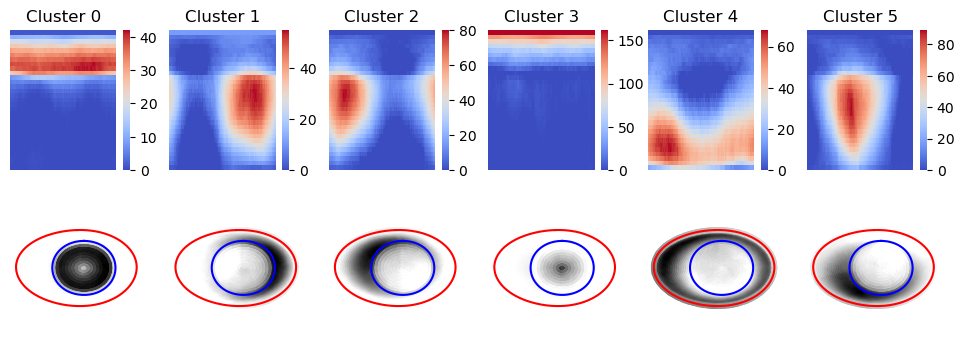

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
avg_cell = np.load(f"{cfg.PROJECT_DIR}/shapemode/{cfg.ALIGNMENT}_{cfg.MODE}/Avg_cell.npz")
nu_centroid = [0, 0]
ix_n = avg_cell["ix_n"]
iy_n = avg_cell["iy_n"]
ix_c = avg_cell["ix_c"]
iy_c = avg_cell["iy_c"]
# Move average shape from zero-centered coords to min=[0,0]
min_x = np.min(ix_c)
min_y = np.min(iy_c)
nu_centroid[0] -= min_x
nu_centroid[1] -= min_y
ix_n -= min_x
iy_n -= min_y
ix_c -= min_x
iy_c -= min_y

from warps import parameterize
x_, y_ = parameterize.get_coordinates(
    np.concatenate([ix_n, iy_n]), 
    np.concatenate([ix_c, iy_c]), 
    nu_centroid, n_isos=cfg.N_ISOS, plot=False
)
x = np.array(x_).round().astype("uint16")
y = np.array(y_).round().astype("uint16")

# Visualize Feature Contributions per Cluster
#plt.figure(figsize=(10, 6))
#sns.heatmap(H, annot=True, cmap='coolwarm', yticklabels=[f'Cluster {i}' for i in range(n_components)])

def visualize_nmf_components(H, pilr0, ix_n, iy_n, ix_c, iy_c):
    n_col = H.shape[0]
    fig, ax = plt.subplots(ncols=n_col, nrows=2, figsize=(2*n_col, 4))
    for i in range(n_col):
        sns.heatmap(H[i].reshape(pilr0.shape), annot=False, cmap='coolwarm', ax=ax[0,i])
        ax[0,i].axis('off')
        ax[0,i].set_title(f'Cluster {i}')
        ax[1,i].scatter(y.flatten(), x.flatten(), c=H[i], cmap='binary', s=10)    
        ax[1,i].plot(iy_n, ix_n, 'b')
        ax[1,i].plot(iy_c, ix_c, 'r')
        ax[1,i].axis('equal')
        ax[1,i].axis('off')
    
    #plt.title('NMF Feature Contributions by Cluster')
    plt.xlabel('Features')
    #plt.ylabel('NMF Components (Clusters)')
    plt.show()

from imageio import imread
def plot_image_collage(paths, n_cols=5, figsize=(20, 20), globalvmax=None):
    n_rows = len(paths) // n_cols# + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(paths):
            if globalvmax:
                ax.imshow(imread(paths[i]), cmap='inferno', vmax=globalvmax)
            else:
                ax.imshow(imread(paths[i]), cmap='inferno')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

from coefficients.coefs import inverse_fft
def plot_avg_shape(fcoef, ax=None):
    n = 128
    fcoef_c = fcoef[0 : n * 2]
    fcoef_n = fcoef[n * 2 :]
    ix_n, iy_n = inverse_fft(fcoef_n[0 : n], fcoef_n[n :])
    ix_c, iy_c = inverse_fft(fcoef_c[0 : n], fcoef_c[n :])
    if ax:
        ax.plot(ix_n, iy_n)
        ax.plot(ix_c, iy_c)
        ax.axis('scaled')
    else:
        plt.plot(ix_n, iy_n)
        plt.plot(ix_c, iy_c)
        plt.axis('scaled')

        
visualize_nmf_components(H, pilr0, ix_n, iy_n, ix_c, iy_c)

In [13]:
from scipy.ndimage import rotate, center_of_mass
from utils.helpers import get_line
from skimage import exposure

fft_shift_path = f"{cfg.PROJECT_DIR}/fftcoefs/{cfg.ALIGNMENT}/shift_error_meta_fft128.txt"
def rotate_and_pad_to_size(img, angle, final_size=(500, 500), cval=0):
    rotated = rotate(img, angle=angle, reshape=True, order=1, mode='constant', cval=cval)
    h, w = rotated.shape
    target_h, target_w = final_size

    # Pad if smaller
    pad_h = max(target_h - h, 0)
    pad_w = max(target_w - w, 0)
    rotated = np.pad(rotated,
        ((pad_h // 2, pad_h - pad_h // 2),
         (pad_w // 2, pad_w - pad_w // 2)),
        mode='constant', constant_values=cval)
    
    # Crop center if larger
    center_y, center_x = rotated.shape[0] // 2, rotated.shape[1] // 2
    final = rotated[
        center_y - target_h // 2 : center_y + target_h // 2,
        center_x - target_w // 2 : center_x + target_w // 2
    ]
    return final


def rotation_and_align(image_path, shape_path, find_pattern, rescale=False, output_size=(600, 600)):
    """Rotate and align the image based on the shift dictionary, return fixed-size outputs."""

    fft_coefs = get_line(fft_shift_path, search_text=find_pattern, mode="first")
    vals = fft_coefs.strip().split(";") 
    theta = float(vals[1])
    print(find_pattern, fft_coefs, fft_shift_path, vals, theta)

    img = plt.imread(image_path)
    if rescale:
        l, h = np.percentile(img, (0, 100))
        img = exposure.rescale_intensity(img, in_range=(l, h))

    protein_ch = rotate_and_pad_to_size(img, angle=theta, final_size=output_size)
    data = np.load(shape_path)
    nuclei = rotate_and_pad_to_size(data[1, :, :], angle=theta, final_size=output_size)
    cell = rotate_and_pad_to_size(data[0, :, :], angle=theta, final_size=output_size)

    center_cell = center_of_mass(cell)
    center_nuclei = center_of_mass(nuclei)

    if center_cell[1] > center_nuclei[1]:  # rotate 180 if flipped
        protein_ch = rotate_and_pad_to_size(protein_ch.copy(), angle=180, final_size=output_size)
        cell = rotate_and_pad_to_size(cell.copy(), angle=180, final_size=output_size)
        nuclei = rotate_and_pad_to_size(nuclei.copy(), angle=180, final_size=output_size)

    return protein_ch, nuclei, cell


/tmp/ipykernel_554571/525337829.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(imgpath.replace('/scratch/users/tle1302','/data').replace('.npy', '_protein.png'))


HPA037708_AURKB/B2AI_1_untreated_G5_R4/45.npy /scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA037708_AURKB/B2AI_1_untreated_G5_R4/45.npy;-38.1106768529524;(244.15230133801597, 289.70054163678185);4.01363206769088;1.2137372675123306
 /data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA037708_AURKB/B2AI_1_untreated_G5_R4/45.npy', '-38.1106768529524', '(244.15230133801597, 289.70054163678185)', '4.01363206769088', '1.2137372675123306'] -38.1106768529524
CAB080426_HDAC8/B2AI_1_untreated_A4_R7/3.npy /scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080426_HDAC8/B2AI_1_untreated_A4_R7/3.npy;-9.493184239962915;(272.6763049721268, 516.4613435441184);7.707484248165839;2.9368203802134074
 /data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080426_HDAC8/B2AI_1_untreated_A4_R7/3.npy', '-9.49318423

HPA026633_UHRF2/B2AI_1_Vorinostat_D2_R6/4.npy /scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA026633_UHRF2/B2AI_1_Vorinostat_D2_R6/4.npy;-38.01892799451394;(130.1496703749485, 154.60269880510918);1.3441371695781743;1.9000055539214928
 /data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA026633_UHRF2/B2AI_1_Vorinostat_D2_R6/4.npy', '-38.01892799451394', '(130.1496703749485, 154.60269880510918)', '1.3441371695781743', '1.9000055539214928'] -38.01892799451394
HPA022133_53BP1/B2AI_1_untreated_B12_R3/12.npy /scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA022133_53BP1/B2AI_1_untreated_B12_R3/12.npy;-179.41910358766683;(207.70472801486173, 270.1806431356132);3.8821301463970346;2.0523271948137167
 /data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA022133_53BP1/B2AI_1_untreated_B12_R3/12.npy'

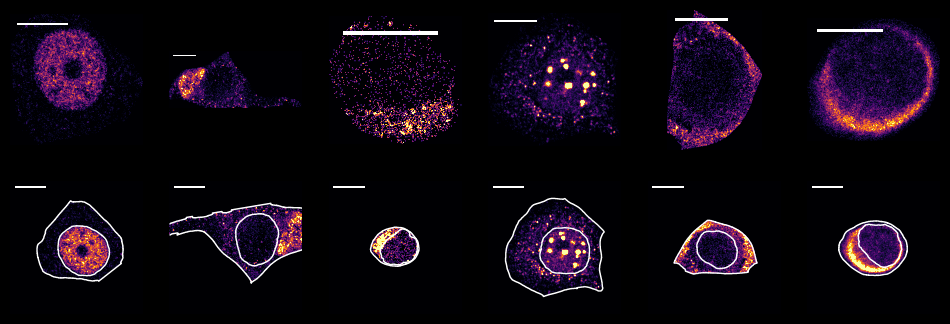

In [14]:
pixel_size = 0.07  # μm/pixel, for B2AI
scale_bar_length_um = 10  # desired length in μm
scale_bar_pixels = int(scale_bar_length_um / pixel_size)
from matplotlib.patches import Rectangle

W_ = np.round(W,2)
W_ /= W_.sum(axis=1, keepdims=True)
fig, ax = plt.subplots(2, 6, figsize=(2*6, 4))
fig.patch.set_facecolor('black')
for i in range(6):
    imgpath = np.array(img_ids)[np.where(W_[:,i] > np.max(W_[:,i])*0.90)][0]
    if i == 5:
        imgpath = "/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080430_DNMT1/B2AI_1_untreated_A8_R1/30.npy"
        imgpath = "/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA008445_YWHAE/B2AI_1_Vorinostat_B11_R12/7.npy"
    img = imread(imgpath.replace('/scratch/users/tle1302','/data').replace('.npy', '_protein.png'))

    ab, sampleid, cellid = imgpath.replace('/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/', '').split('/')
    rotated_img, nuclei_mask, cell_mask = rotation_and_align(image_path=imgpath.replace('/scratch/users/tle1302','/data').replace('.npy', '_protein.png'),
                    shape_path=imgpath.replace('/scratch/users/tle1302','/data'),
                    find_pattern=f"{ab}/{sampleid}/{cellid[:-4]}.npy")
    ax[0, i].imshow(img, origin='lower', cmap='inferno', vmax=np.percentile(img, 99))
    ax[0, i].axis('off') 

    # Draw white rectangle scale bar in bottom left corner
    scale_bar = Rectangle(
        (20, img.shape[0] - 30),  # x, y: start near bottom-left
        width=scale_bar_pixels,  # 10 µm in pixel units
        height=6,
        linewidth=0,
        edgecolor=None,
        facecolor='white'
    )
    ax[0, i].add_patch(scale_bar)
    

    ax[1, i].imshow(rotated_img, origin='lower', cmap='inferno', vmin=np.percentile(rotated_img, 10), vmax=np.percentile(rotated_img, 99))
    ax[1, i].contour(cell_mask > 0, colors='white', linewidths=1, alpha=1)
    ax[1, i].contour(nuclei_mask > 0, colors='white', linewidths=1, alpha=1)
    ax[1, i].axis('off')

    # Draw white rectangle scale bar in bottom left corner
    scale_bar = Rectangle(
        (20, rotated_img.shape[0] - 30),  # x, y: start near bottom-left
        width=scale_bar_pixels,  # 10 µm in pixel units
        height=6,
        linewidth=0,
        edgecolor=None,
        facecolor='white'
    )
    ax[1, i].add_patch(scale_bar)
    

/tmp/ipykernel_554571/2803497925.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(imgpath.replace('/scratch/users/tle1302','/data').replace('.npy', '_protein.png'))


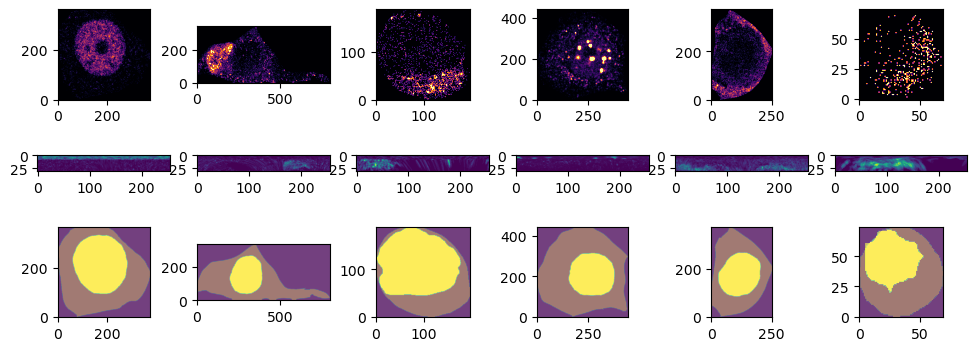

In [15]:
W_ = np.round(W,2)
W_ /= W_.sum(axis=1, keepdims=True)
fig, ax = plt.subplots(3, 6, figsize=(2*6, 4))
for i in range(6):
    imgpath = np.array(img_ids)[np.where(W_[:,i] > np.max(W_[:,i])*0.9 )][0]
    if i == 5:
        imgpath = "/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080430_DNMT1/B2AI_1_untreated_A8_R1/30.npy"
        imgpath = "/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA022133_53BP1/B2AI_1_Paclitaxel_B12_R1/5.npy"
    img = imread(imgpath.replace('/scratch/users/tle1302','/data').replace('.npy', '_protein.png'))
    ax[0, i].imshow(img, origin='lower', cmap='inferno', vmax=np.percentile(img, 99))
    ab, sampleid, cellid = imgpath.replace('/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/', '').split('/')
    pilr_path = f'/data/2Dshapespace/B2AI/sampled_intensity_bin/{ab}_{sampleid}_{cellid[:-4]}_protein.npy'
    ax[1, i].imshow(np.load(pilr_path))
    data = np.load(imgpath.replace('/scratch/users/tle1302','/data'))
    ax[2, i].imshow(data[0,:,:], alpha=0.5, origin='lower')
    ax[2, i].imshow(data[1,:,:], alpha=0.5, origin='lower')
    

Reconstruction error A: 21346.812571921535
Reconstruction error B: 6671.067952685597


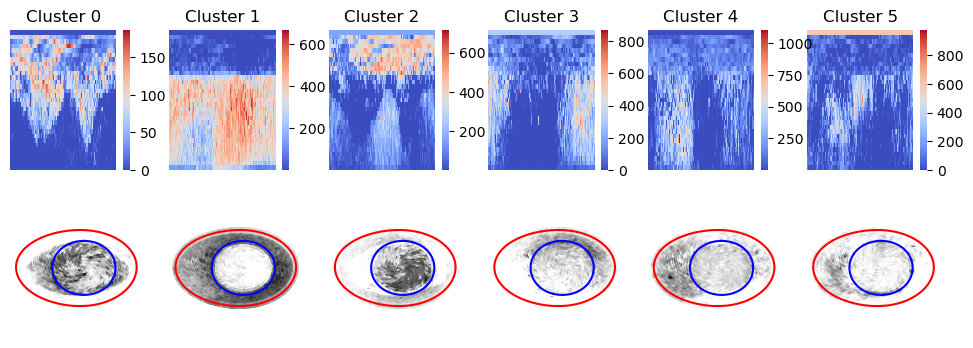

In [16]:
# NMF on a specific protein

unique_proteins = np.unique(proteins) 
data_untreated = pilr_d['untreated'][np.where(np.array(proteins_untreated) == unique_proteins[3])]
data_vorinostat = pilr_d['vorinostat'][np.where(np.array(proteins_vorinostat) == unique_proteins[3])]

# Assuming X_A and X_B are your datasets for conditions A and B
n_components = 6 #min(X_A.shape[1], X_B.shape[1])  # or a smaller number

nmf_A = NMF(n_components=n_components, random_state=45, solver='mu', beta_loss = 'kullback-leibler')
W_A = nmf_A.fit_transform(data_untreated)
H_A = nmf_A.components_

nmf_B = NMF(n_components=n_components, random_state=45, solver='mu', beta_loss = 'kullback-leibler')
W_B = nmf_B.fit_transform(data_vorinostat)
H_B = nmf_B.components_
print(f"Reconstruction error A: {nmf_A.reconstruction_err_}")
print(f"Reconstruction error B: {nmf_B.reconstruction_err_}")

visualize_nmf_components(H_A, pilr0, ix_n, iy_n, ix_c, iy_c)

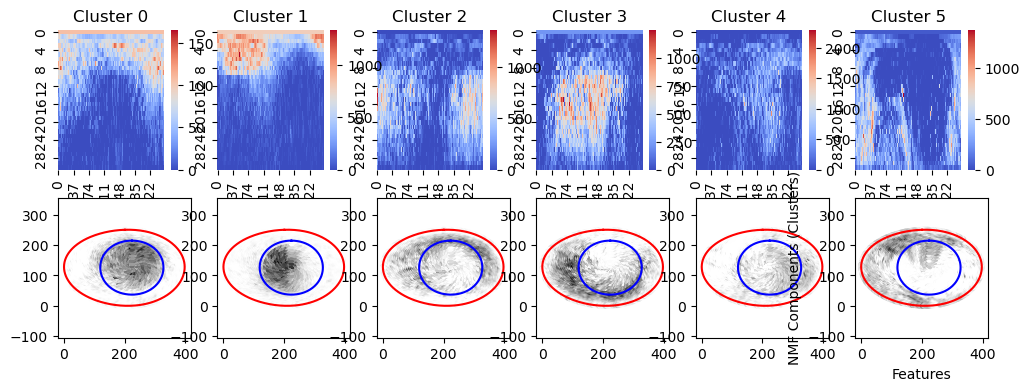

In [ ]:
visualize_nmf_components(H_B, pilr0, ix_n, iy_n, ix_c, iy_c)

# Measure of translocation by distribution shift

In [17]:
from scipy.stats import wasserstein_distance
#clustermix = pd.DataFrame(W)
unique_proteins = np.unique(proteins)
wd_treatment = []
for protein_name in unique_proteins:
    #protein_name = unique_proteins[10]
    W_ = np.round(W,2)[np.where(np.array(proteins) == protein_name)]
    W_ /= W_.sum(axis=1, keepdims=True)
    clustermix = pd.DataFrame(W_)
    clustermix['Cluster'] = cluster_labels[np.where(np.array(proteins) == protein_name)]
    clustermix['Proteins'] = protein_name #proteins[np.where(np.array(proteins) == 'HPA019662_HDAC10')]
    clustermix['Treatment'] = np.array(treatments)[np.where(np.array(proteins) == protein_name)[0]]
    clustermix['Image'] = np.array(img_ids)[np.where(np.array(proteins) == protein_name)[0]]

    pivot_df0 = clustermix[[0,1,2,3,4,5,'Treatment']].groupby('Treatment').mean()
    pivot_df0 = pivot_df0.div(pivot_df0.sum(axis=1), axis=0)

    pivot_df = clustermix.groupby(["Treatment", "Cluster"]).size().unstack(fill_value=0)
    pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)
    #pivot_df.plot(kind='barh', stacked=True, figsize=(4, 2))
    wd_treatment.append([protein_name, 
                         wasserstein_distance(pivot_df.T.untreated, pivot_df.T.vorinostat), 
                         wasserstein_distance(pivot_df.T.untreated, pivot_df.T.paclitaxel),
                         wasserstein_distance(pivot_df0.T.untreated, pivot_df0.T.vorinostat),
                         wasserstein_distance(pivot_df0.T.untreated, pivot_df0.T.paclitaxel)])
    
wd_treatment = pd.DataFrame(wd_treatment, columns=['Protein', 'untreated_vorinostat', 'untreated_paclitaxel', 'untreated_vorinostat_fractional', 'untreated_paclitaxel_fractional'])

In [18]:
pivot_df0 = clustermix[[0,1,2,3,4,5,'Treatment']].groupby('Treatment').mean()
pivot_df0 = pivot_df0.div(pivot_df0.sum(axis=1), axis=0)

In [20]:
wd_treatment.sort_values('untreated_vorinostat_fractional', ascending=False).head(10)

,Protein,untreated_vorinostat,untreated_paclitaxel,untreated_vorinostat_fractional,untreated_paclitaxel_fractional
38,HPA026588_DNMT3A,0.104987,0.069899,0.142283,0.109305
44,HPA028926_HDAC9,0.218929,0.215817,0.116156,0.111997
9,HPA001023_PHF6,0.240225,0.193796,0.085690,0.062310
69,HPA051773_BRE1A,0.194915,0.141069,0.079730,0.055883
10,HPA001075_TAF1,0.235294,0.226692,0.079587,0.094418
27,HPA012008_CHD4,0.202600,0.116119,0.069393,0.058021
31,HPA021152_PDP1,0.150173,0.051286,0.065132,0.035118
21,HPA006104_KAT6B,0.114286,0.008163,0.063946,0.020669
64,HPA048340_BRG1,0.117197,0.025804,0.060551,0.008027
2,CAB080425_KAT2A,0.041176,0.012500,0.057220,0.028914


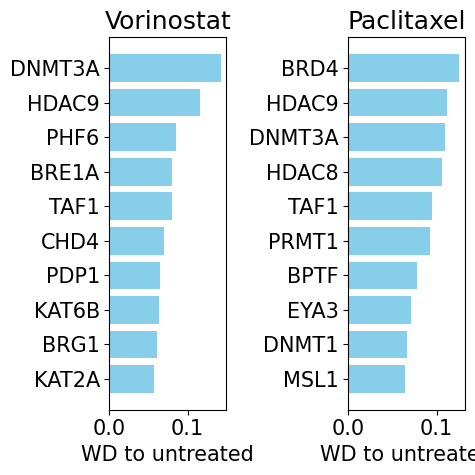

In [21]:
# Sorting and selecting top 10 proteins based on each condition
wd_treatment['Protein_name'] = [f.split('_')[1] for f in wd_treatment.Protein]
df_vorinostat = wd_treatment.sort_values(by="untreated_vorinostat_fractional", ascending=False).head(10)
df_paclitaxel = wd_treatment.sort_values(by="untreated_paclitaxel_fractional", ascending=False).head(10)

plt.rcParams['font.size'] = 15
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

# Vorinostat barplot
axes[0].barh(df_vorinostat["Protein_name"], df_vorinostat["untreated_vorinostat_fractional"], color='skyblue')
axes[0].set_xlabel("WD to untreated")
axes[0].set_title("Vorinostat")
axes[0].invert_yaxis()  # Highest values on top

# Paclitaxel barplot
axes[1].barh(df_paclitaxel["Protein_name"], df_paclitaxel["untreated_paclitaxel_fractional"], color='skyblue')
axes[1].set_xlabel("WD to untreated")
axes[1].set_title("Paclitaxel")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

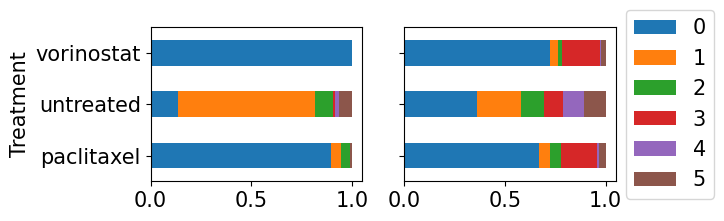

In [29]:
protein_name = 'HPA026588_DNMT3A' # untreated all locations, vorinostat -> just nucleus
#protein_name = "HPA001023_PHF6"#"HPA061646_BRD4"#"HPA026588_DNMT3A"#"HPA006104_KAT6B"#"HPA023567_MSL1"#"HPA061646_BRD4"#"HPA021152_PDP1"
clustermix = pd.DataFrame(W[np.where(np.array(proteins) == protein_name)])
clustermix['Cluster'] = cluster_labels[np.where(np.array(proteins) == protein_name)]
clustermix['Proteins'] = protein_name #proteins[np.where(np.array(proteins) == 'HPA019662_HDAC10')]
clustermix['Treatment'] = np.array(treatments)[np.where(np.array(proteins) == protein_name)[0]]
clustermix['Image'] = np.array(img_ids)[np.where(np.array(proteins) == protein_name)[0]]

fig, ax = plt.subplots(1, 2, figsize=(6, 2), sharex=True, sharey=True)
pivot_df = clustermix.groupby(["Treatment", "Cluster"]).size().unstack(fill_value=0)
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)
pivot_df.plot(kind='barh', stacked=True, ax=ax[0])
ax[0].legend().set_visible(False)


pivot_df0 = clustermix[[0,1,2,3,4,5,'Treatment']].groupby('Treatment').mean()
pivot_df0 = pivot_df0.div(pivot_df0.sum(axis=1), axis=0)
pivot_df0.plot(kind='barh', stacked=True, ax=ax[1])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

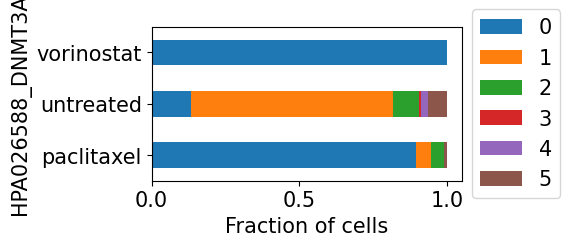

In [23]:
#pilr_d['untreated'][0].max(), pilr_d['vorinostat'][0].max(), pilr_d['paclitaxel'][0].max()
#clustermix[(clustermix.Cluster == 0) & (clustermix.Treatment == 'vorinostat')]
#clustermix[(clustermix.Treatment == 'vorinostat')].Cluster.value_counts()
pivot_df = clustermix.groupby(["Treatment", "Cluster"]).size().unstack(fill_value=0)
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)
pivot_df.plot(kind='barh', stacked=True, xlabel='Fraction of cells', ylabel=protein_name, figsize=(4, 2))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

/tmp/ipykernel_554571/3940950016.py:57: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ax.imshow(imread(paths[i]), cmap='inferno', vmax=globalvmax)


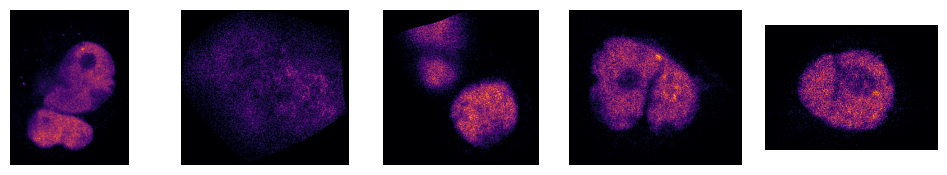

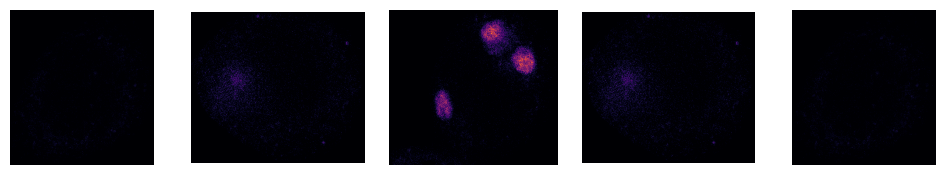

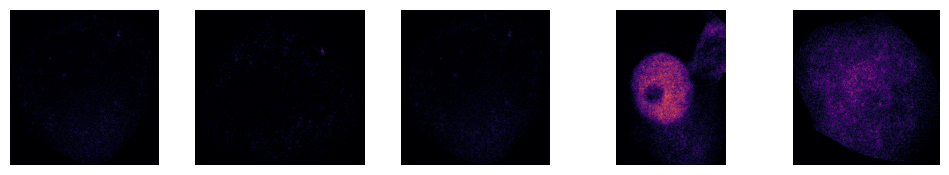

Cluster 3 not found
Cluster 4 not found


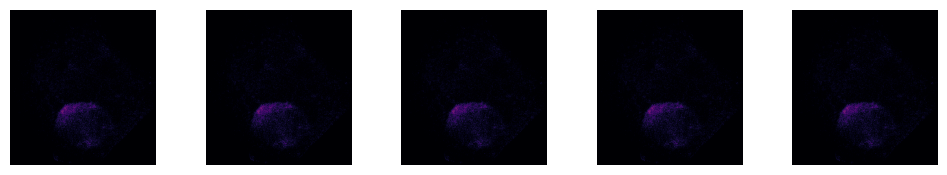

In [30]:
#from analysis.organelle_heatmap_helpers import plot_image_collage
global_max = pilr_d['untreated'].max()

for i in range(6):
    try:
        imglist = clustermix[(clustermix.Cluster == i) & (clustermix.Treatment == 'paclitaxel')].sample(5, replace=True).Image.tolist()#[:5]
        if len(imglist) == 0:
            continue
        imglist = [f.replace('/scratch/users/tle1302/2Dshapespace','/data/2Dshapespace').replace('.npy','_protein.png') for f in imglist]
        plot_image_collage(imglist, n_cols=5, figsize=(10,2), globalvmax=global_max)
    except:
        print(f"Cluster {i} not found")

HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R3/5.npy /scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R3/5.npy;-61.62306304691629;(242.59436213903282, 303.2695508203066);5.868435882579506;1.933125215366237
 /data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R3/5.npy', '-61.62306304691629', '(242.59436213903282, 303.2695508203066)', '5.868435882579506', '1.933125215366237'] -61.62306304691629
HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R4/28.npy /scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R4/28.npy;-169.34763062016026;(166.0625264404772, 157.28251121076232);2.1153732824186657;0.9363443950588506
 /data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R4/28.np

Cluster 3 not found
Cluster 4 not found
HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R4/15.npy /scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R4/15.npy;-115.93499150938122;(249.96636310792482, 256.16837822127496);2.332481471484419;0.7119937398222889
 /data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R4/15.npy', '-115.93499150938122', '(249.96636310792482, 256.16837822127496)', '2.332481471484419', '0.7119937398222889'] -115.93499150938122


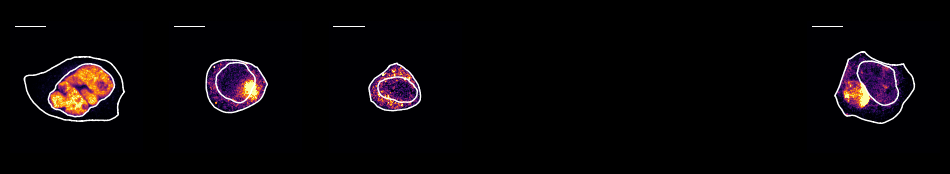

In [32]:
fig, ax = plt.subplots(1, 6, figsize=(2*6, 2))
fig.patch.set_facecolor('black')

for i in range(6):
    try:
        imglist = clustermix[(clustermix.Cluster == i) & (clustermix.Treatment == 'paclitaxel')].sample(2, replace=True).Image.tolist()#.sample(2, replace=True).Image.tolist()
        #if len(imglist) == 0:
        #    continue
        #imglist = [f.replace('/scratch/users/tle1302/2Dshapespace','/data/2Dshapespace').replace('.npy','_protein.png') for f in imglist]
        imgpath = imglist[0]
        ab, sampleid, cellid = imgpath.replace('/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/', '').split('/')
        rotated_img, nuclei_mask, cell_mask = rotation_and_align(image_path=imgpath.replace('/scratch/users/tle1302','/data').replace('.npy', '_protein.png'),
                        shape_path=imgpath.replace('/scratch/users/tle1302','/data'),
                        find_pattern=f"{ab}/{sampleid}/{cellid[:-4]}.npy")
        #ax[0, i].imshow(img, origin='lower', cmap='inferno', vmax=np.percentile(img, 99))
        #ax[0, i].axis('off') 
        ax[i].imshow(rotated_img, origin='lower', cmap='inferno', vmin=np.percentile(rotated_img, 15), vmax=np.percentile(rotated_img, 99))
        ax[i].contour(cell_mask > 0, colors='white', linewidths=1, alpha=1)
        ax[i].contour(nuclei_mask > 0, colors='white', linewidths=1, alpha=1)
        ax[i].axis('off')
    except:
        print(f"Cluster {i} not found")
        #ax[1,i].imshow(np.zeros((128,128)), vmin=10, vmax=20)
        ax[i].axis('off')
    
    # Draw white rectangle scale bar in bottom left corner
    scale_bar = Rectangle(
        (20, rotated_img.shape[0] - 30),  # x, y: start near bottom-left
        width=scale_bar_pixels,  # 10 µm in pixel units
        height=6,
        linewidth=0,
        edgecolor=None,
        facecolor='white'
    )
    ax[i].add_patch(scale_bar)

# Number of reasonable components search

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


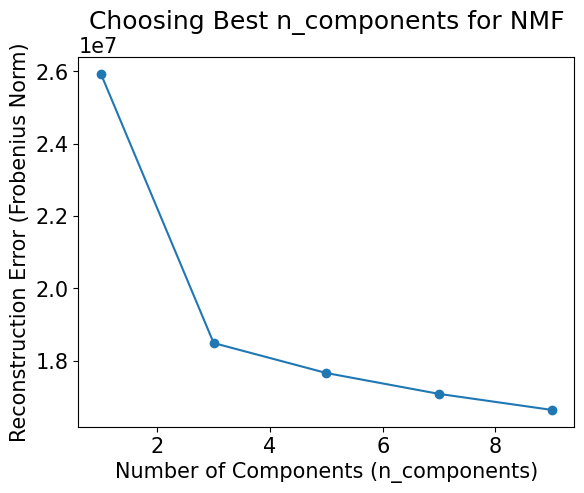

In [34]:
errors = []
components = range(1, 10 + 1, 2)

for n in components:
    model = NMF(n_components=n, init='random', random_state=42, max_iter=200)
    W = model.fit_transform(alldata)  # Sample-to-component matrix
    #H = model.components_
    #reconstruction = np.dot(W, H)
    #error = np.linalg.norm(alldata - reconstruction, 'fro')  # Frobenius norm
    #print(f"n_components={n}, error={error}, reconstruction_error {model.reconstruction_err_}")
    #errors.append(error)
    errors.append(model.reconstruction_err_)
# Plot the reconstruction error
plt.plot(components, errors, marker='o', linestyle='-')
plt.xlabel("Number of Components (n_components)")
plt.ylabel("Reconstruction Error (Frobenius Norm)")
plt.title("Choosing Best n_components for NMF")
plt.show()